In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from rgm import *

In [3]:
file_name = "5.npz"
path = "../../../data/walker/run/"

res = onp.load(path + file_name)

In [4]:
res["observation"].shape

(501, 3, 64, 64)

In [5]:
!pip install -q mediapy


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


walker

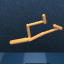

In [6]:
import mediapy

ims = [onp.transpose(res["observation"][i], (1, 2, 0)) for i in range(128)]

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"walker": ims}, width=320, height=320, fps=20, codec='gif')

In [7]:
observations = onp.transpose(res["observation"], (0, 2, 3, 1))
actions = res["action"]

In [8]:
num_frames = 128
offset = 0

observations = observations[offset : offset + num_frames]
actions = actions[offset : offset + num_frames]

In [9]:
rgm = RGM()
rgm.fit(observations, actions)

Maximum probability state about factor 0 at time 0: 31
Maximum probability state about factor 0 at time 1: 20
Maximum probability state about factor 0 at time 2: 10
Maximum probability state about factor 0 at time 3: 43
Maximum probability state about factor 0 at time 4: 41
Maximum probability state about factor 0 at time 5: 22
Maximum probability state about factor 0 at time 6: 4
Maximum probability state about factor 0 at time 7: 2
Maximum probability state about factor 0 at time 8: 29
Maximum probability state about factor 0 at time 9: 23
Maximum probability state about factor 0 at time 10: 12
Maximum probability state about factor 0 at time 11: 8
Maximum probability state about factor 0 at time 12: 37
Maximum probability state about factor 0 at time 13: 60
Maximum probability state about factor 0 at time 14: 47
Maximum probability state about factor 0 at time 15: 6
Maximum probability state about factor 0 at time 16: 27
Maximum probability state about factor 0 at time 17: 30
Maximu

In [10]:
rgm.save("runner.npz")

In [11]:
qs = rgm.infer_states(observations[:4], actions[:4], None)

In [12]:
print(qs)

[Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)]


In [13]:
imgs, u = rgm.reconstruct(qs)
print(u)

[[ 0.    0.    0.    0.    0.    0.  ]
 [ 0.5  -1.    0.75  0.5  -0.75  0.25]
 [ 1.   -1.    0.25  1.   -1.    0.75]
 [ 1.   -1.    0.5   1.   -1.   -1.  ]]


reconstruction

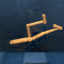

In [14]:
import mediapy

mediapy.show_videos({"reconstruction": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif")

In [15]:
priors = rgm.infer_empirical_prior(jnp.array([[0]]), qs)

In [16]:
qs_next = rgm.infer_states(observations[4:8], actions[4:8], priors)

In [17]:
print(qs_next)

[Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],      dtype=float32)]


[[ 1.   -1.    1.    1.   -0.75 -1.  ]
 [ 0.75  1.    0.75 -0.5  -1.   -1.  ]
 [-1.    1.    1.   -1.   -1.    0.5 ]
 [-1.    1.    1.   -0.75 -1.    1.  ]]


prediction

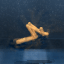

In [18]:
imgs, u = rgm.reconstruct(qs_next)
print(u)
mediapy.show_videos({"prediction": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif")

In [5]:
from dm_control import manipulation, suite
from dm_control.suite.wrappers import pixels

seed = 0
domain = "walker"
task = "run"
img_size = 64

env = suite.load(
    domain,
    task,
    task_kwargs=dict(random=seed),
    environment_kwargs=dict(flat_observation=True),
)

# zoom in camera for quadruped
camera_id = dict(locom_rodent=1, quadruped=2).get(domain, 0)
render_kwargs = dict(height=img_size, width=img_size, camera_id=camera_id)
env = pixels.Wrapper(env, pixels_only=True, render_kwargs=render_kwargs)
env._size = (img_size, img_size)
env._camera = camera_id

100%|██████████| 64/64 [01:14<00:00,  1.17s/it]


control,imagined

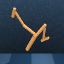
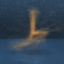

In [8]:
import mediapy
from tqdm import tqdm

imgs = []
recs = []

rgm = RGM()
rgm.load("runner.npz")
agent = RGMAgent(rgm)

ts, reward, discount, obs = env.reset()
imgs.append(obs["pixels"])
for i in tqdm(range(64)):
    action, im = agent.act(obs)
    ts, reward, discount, obs = env.step(action)
    imgs.append(obs["pixels"])
    recs.append(im)

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"control": imgs, "imagined": recs}, width=320, height=320, fps=20, codec="gif")

[Array([[4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 4.930436e-32, 4.930436e-32,
        4.930436e-32, 4.930436e-32, 1.000000e+00, 4.930436e-32]],      dtype=float32)]


gt,model

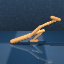
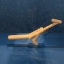

In [33]:
import jax.numpy as jnp
offset = 9
input = imgs[offset*4:offset*4+4]
qs = rgm.infer_states(jnp.asarray(input), None, None)
print(qs)
recs, u = rgm.reconstruct(qs)
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"gt": [im for im in input], "model": [im for im in recs]}, width=320, height=320, fps=2, codec="gif")

In [28]:
print(u)

[[ 1.0000000e+00  7.5000000e-01  7.5000000e-01 -7.5000000e-01
  -7.5000000e-01 -7.5000000e-01]
 [ 1.0000000e+00  1.0000000e+00 -2.5000000e-01 -5.0000000e-01
  -1.8489137e-31 -1.0000000e+00]
 [ 1.0000000e+00  1.0000000e+00 -1.0000000e+00 -7.5000000e-01
   5.0000000e-01 -7.5000000e-01]
 [ 1.0000000e+00  1.0000000e+00 -1.0000000e+00 -1.0000000e+00
   7.5000000e-01  7.5000000e-01]]


imagination

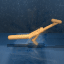

In [34]:
observations, beliefs = predict(rgm.agents, qs, jnp.array([[0]]), num_steps=10)
i,a = rgm.discrete_2_rgb_action(observations[0])
with mediapy.set_show_save_dir("."):
    mediapy.show_videos(
        {"imagination": [im for im in i]}, width=320, height=320, fps=20, codec="gif"
    )

actual

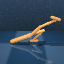

In [35]:
actual = imgs[offset * 4 : offset * 4 + 40]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"actual": [im for im in actual]}, width=320, height=320, fps=20, codec="gif")